In [3]:
!pip install natsort

**Reading data**

In [0]:
# HTTP
from requests import get

# OS and IO
from io import BytesIO

# Unzipping
from zipfile import ZipFile

# Science and shi*
import scipy
import matplotlib.pyplot as plt
import numpy as np

# For sorting files
from natsort import natsorted

# Read files in order
request = get('http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip')
zip_file = ZipFile(BytesIO(request.content))
files = zip_file.namelist()
files = natsorted(files)
zip_file.extractall()

# Convert images to training and test data matrices:
y = np.arange(1, 41, 1)
y = np.repeat(y, 10).reshape(400, 1)
ytest = y[1::2, ::]
ytraining = y[0::2, ::]
D = np.array(np.empty([0, 10304]))

for f in files:
    if f.endswith(".pgm"):
        arr = scipy.misc.imread(f)
        # The array is transposed because I checked its dimensions and they were 112X92
        arr = arr.T
        D = np.vstack((D, arr.flatten()))
        
Dtest = D[1::2, ::]
Dtraining = D[0::2, ::]

# 200 training examples with 10304 feature/pixel
assert Dtraining.shape == (200, 10304)

# 200 test examples with 10304 feature/pixel
assert Dtest.shape == (200, 10304)



**LDA**

In [15]:
means = np.array(np.empty([0, 10304]))
for i in range(0, 200, 5):
    user = Dtraining[i:i+5:, ::]
    mean = np.mean(user, axis=0)
    means = np.vstack((means, mean))
    
print(means.shape)
n = means.shape[0]
#Because python returns mean vector as row not column vector, therefore we reversed the equation
overall_mean = np.mean(Dtraining, axis=0)
B = np.zeros((10304, 10304))
for i in range(0, n): 
    overall_mean = overall_mean.reshape(10304,1) 
    mean_vec = means[i].reshape(10304,1)
    B += 5 * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    i += 1
Z = np.array(np.empty([0, 10304]))
j = 0
for i in range(0, 200, 5):
    user = Dtraining[i:i+5:, ::]
    Z = np.vstack((Z, user-means[j].T))
    j += 1

#This is S, we don't have to sum all Ss from 1 to 40, I tested that with an example here https://pastebin.com/TABBdB5C    
S = Z.T.dot(Z)
S_inverse = np.linalg.inv(S)
S_inverse_B = S_inverse.dot(B)
U, S, V = np.linalg.svd(S_inverse_B)
eigen_values, eigen_vectors = np.square(S), V.T
assert eigen_vectors.shape == (10304, 10304)


(40, 10304)


** Viewing First 10 Eigen Faces**

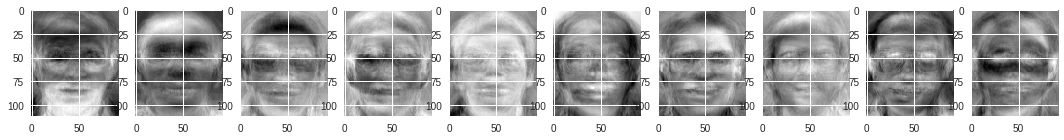

In [17]:
def face_from_vector(v, dimensions=(92, 112)):
  return v.reshape(dimensions).T

# image size
fig=plt.figure(figsize=(92/5, 112/5))

# rendering 10 images next to each other
rows, columns = 1, 10
for i in range(0, 10):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(face_from_vector(eigen_vectors[:,i]), cmap='gray', interpolation='nearest');

**Projection, classification and calculating accuracy**

In [21]:
U = eigen_vectors[:,range(0,39)]
assert U.shape == (10304, 39)
project_trainning = Dtraining.dot(U)
project_test = Dtest.dot(U)
print(project_test.shape)
print(ytest.shape)

# importing necessary libraries
from sklearn import datasets
from sklearn.model_selection import train_test_split
 
# training a KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 1, weights='distance').fit(project_trainning, np.ravel(ytraining))
 
# accuracy on Dtest
accuracy = knn.score(project_test, ytest)
print (accuracy)
# Classifying trainning data
Ztrain = knn.predict(project_trainning)
print(Ztrain)
# Classifying test data
Ztest = knn.predict(project_test)
print(Ztest)


(200, 39)
(200, 1)
0.96
[ 1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4  4  5  5  5  5
  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9  9  9 10 10 10
 10 10 11 11 11 11 11 12 12 12 12 12 13 13 13 13 13 14 14 14 14 14 15 15
 15 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 19 19 19 19 19 20
 20 20 20 20 21 21 21 21 21 22 22 22 22 22 23 23 23 23 23 24 24 24 24 24
 25 25 25 25 25 26 26 26 26 26 27 27 27 27 27 28 28 28 28 28 29 29 29 29
 29 30 30 30 30 30 31 31 31 31 31 32 32 32 32 32 33 33 33 33 33 34 34 34
 34 34 35 35 35 35 35 36 36 36 36 36 37 37 37 37 37 38 38 38 38 38 39 39
 39 39 39 40 40 40 40 40]
[ 1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4  4  5  5  5  5
 40  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9  9  9 10 10 10
 10  8 11 11 11 11 11 12 12 12 12 12 13 13 13 13 13 14 14 14 14 14 15 15
 15 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 19 19 19 19 19 20
 20 20 20 20 21 21 21 21 21 22 22 22 22 22 23 23 23 23 23 24 24 24 24 24
 